In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import datetime

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-11-25 10:32:31.359201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:


# import tensorflow as tf
# tf.config.run_functions_eagerly(True)      # avoids graph tracing stalls
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import RootMeanSquaredError

In [3]:
df = pd.read_csv('/Users/Ptanner/ml_projects/uci_eletric_power_consumption_rnn/data/hourly_mean_global_active_power.csv')
df.head()
df_filled = df.fillna(method="ffill").fillna(method="bfill")

/var/folders/0t/5lm7h_6s6qq4j86y_q6lq9880000gp/T/ipykernel_46564/3214698729.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df.fillna(method="ffill").fillna(method="bfill")


In [4]:
df_filled['DateTime'] = pd.to_datetime(df['DateTime'])
df_filled.set_index('DateTime', inplace=True)

In [ ]:
# df.drop(columns=['DateTime'], inplace=True)

(34589,)

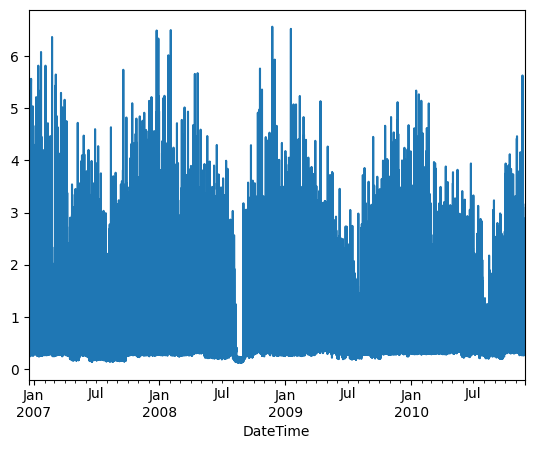

In [5]:
power_hourly = df_filled['Global_active_power']
power_hourly.plot()

power_hourly.shape

In [6]:
print(power_hourly.isna().sum())  # should all be 0
print("Rows before:", len(df), "Rows after:", len(power_hourly))

0
Rows before: 34589 Rows after: 34589


In [7]:
def df_to_X_y(df, window_size = 5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [8]:
WINDOW_SIZE = 5
# power_hourly = hourly_mean 
X,y = df_to_X_y(df =power_hourly, window_size=WINDOW_SIZE)
print(f'X shape:{X.shape}')
print(f'Y shape {y.shape}')

X shape:(34584, 5, 1)
Y shape (34584,)


In [9]:
print(f'X[0]: {X[0]}, y[0]: {y[0]}')
print(f'X[1]: {X[1]}, y[1]: {y[1]}')
print(f'X[2]: {X[2]}, y[2]: {y[2]}')

X[0]: [[4.22288889]
 [3.6322    ]
 [3.40023333]
 [3.26856667]
 [3.05646667]], y[0]: 2.200133333333333
X[1]: [[3.6322    ]
 [3.40023333]
 [3.26856667]
 [3.05646667]
 [2.20013333]], y[1]: 2.0616
X[2]: [[3.40023333]
 [3.26856667]
 [3.05646667]
 [2.20013333]
 [2.0616    ]], y[2]: 1.8824666666666665


In [10]:
def train_test_val_split_series(X: pd.Series, y: pd.Series, train_size = 0.7, val_size = 0.15):
  train_split = int(len(X) * train_size)
  val_split = int(len(X) * (train_size + val_size))

  X_train = X[:train_split]
  y_train = y[:train_split]

  X_val = X[train_split:val_split]
  y_val = y[train_split:val_split]

  X_test = X[val_split:]
  y_test = y[val_split:]

  return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_val_split_series(X=X, y=y)
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape:{y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')  


# X_train.shape, y_train.shape




X_train shape: (24208, 5, 1)
X_val shape: (5188, 5, 1)
X_test shape: (5188, 5, 1)
y_train shape:(24208,)
y_val shape: (5188,)
y_test shape: (5188,)


In [12]:
###Implement test model

model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
# model1.add(Dense(32,'relu'))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()


2025-11-25 10:34:50.086761: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-11-25 10:34:50.087000: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-25 10:34:50.087176: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-25 10:34:50.088067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-25 10:34:50.088791: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


2025-11-25 10:34:50.695887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-11-25 10:34:50.697107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-11-25 10:34:50.697816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
# os.makedirs("model1", exist_ok=True)
# cp = ModelCheckpoint("model1/checkpoint.keras", save_best_only=True)

In [13]:
cp = ModelCheckpoint('model1/checkpoint.models.keras', save_best_only = True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics = [RootMeanSquaredError()])


In [ ]:
# history = model1.fit(X_train[:128], y_train[:128],
#                      validation_data=(X_val[:128], y_val[:128]),
#                      epochs=1, verbose=2)
# print("Done ✅")

In [14]:
model1.fit(X_train,y_train, validation_data=(X_val,y_val), callbacks =[cp], epochs = 10,verbose = 2)

Epoch 1/10


2025-11-25 10:35:08.070830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-11-25 10:35:08.071967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-11-25 10:35:08.072989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

757/757 - 12s - loss: 0.4939 - root_mean_squared_error: 0.7028 - val_loss: 0.3993 - val_root_mean_squared_error: 0.6319 - 12s/epoch - 16ms/step
Epoch 2/10
757/757 - 10s - loss: 0.4072 - root_mean_squared_error: 0.6382 - val_loss: 0.3882 - val_root_mean_squared_error: 0.6230 - 10s/epoch - 13ms/step
Epoch 3/10
757/757 - 9s - loss: 0.4045 - root_mean_squared_error: 0.6360 - val_loss: 0.3857 - val_root_mean_squared_error: 0.6211 - 9s/epoch - 13ms/step
Epoch 4/10
757/757 - 9s - loss: 0.4026 - root_mean_squared_error: 0.6345 - val_loss: 0.3857 - val_root_mean_squared_error: 0.6210 - 9s/epoch - 12ms/step
Epoch 5/10
757/757 - 9s - loss: 0.4015 - root_mean_squared_error: 0.6336 - val_loss: 0.3831 - val_root_mean_squared_error: 0.6190 - 9s/epoch - 12ms/step
Epoch 6/10
757/757 - 9s - loss: 0.3997 - root_mean_squared_error: 0.6322 - val_loss: 0.3858 - val_root_mean_squared_error: 0.6211 - 9s/epoch - 12ms/step
Epoch 7/10
757/757 - 9s - loss: 0.3993 - root_mean_squared_error: 0.6319 - val_loss: 0.38

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/checkpoint.models.keras')


2025-11-25 10:36:47.636540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-11-25 10:36:47.637240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-11-25 10:36:47.638332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

type(model1)

In [16]:
type(model1)

keras.engine.sequential.Sequential

2025-11-25 10:38:44.889384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-11-25 10:38:44.890256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-11-25 10:38:44.891703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

757/757 [==============================] - 3s 4ms/step


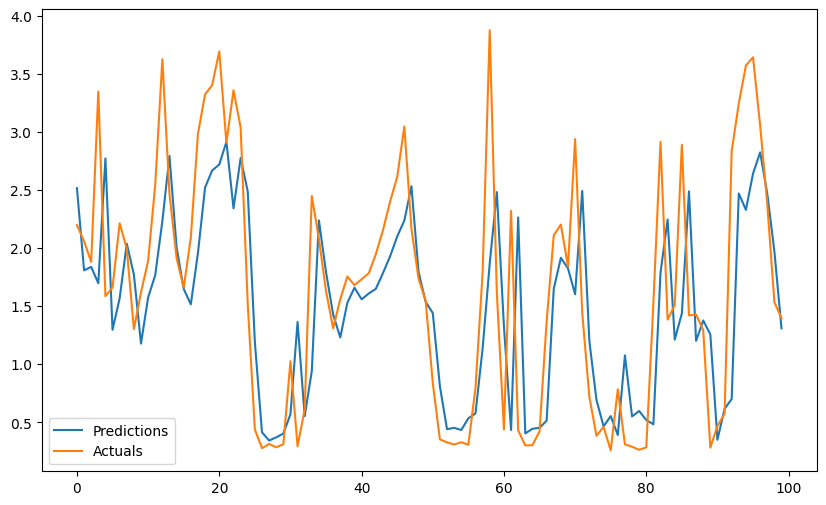

In [17]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Train Actuals': y_train})

plt.figure(figsize=(10,6))
plt.plot(train_results['Train Predictions'][:100], label='Predictions')
plt.plot(train_results['Train Actuals'][:100], label='Actuals')
plt.legend()
plt.show()

163/163 [==============================] - 1s 4ms/step


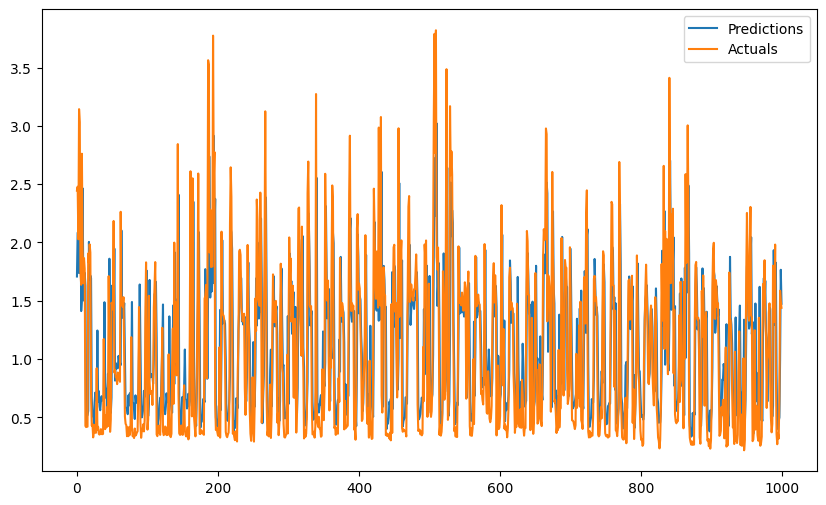

In [19]:
test_predicitions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data = {'Test Predictions': test_predicitions, 'Test Actuals': y_test})

plt.figure(figsize=(10,6))
plt.plot(test_results['Test Predictions'][:1000], label='Predictions')
plt.plot(test_results['Test Actuals'][:1000], label='Actuals')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error